In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 120 # Number of time points
time = np.arange(n_points)

# Generate base binary time series using Bernoulli distribution
X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)

# Introduce causal relationships
for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.95 * X1[t-1])
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.95 * X2[t-1] )


#print(X1)

X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.2 for i in range(len(X3)) if X3[i] > 0]

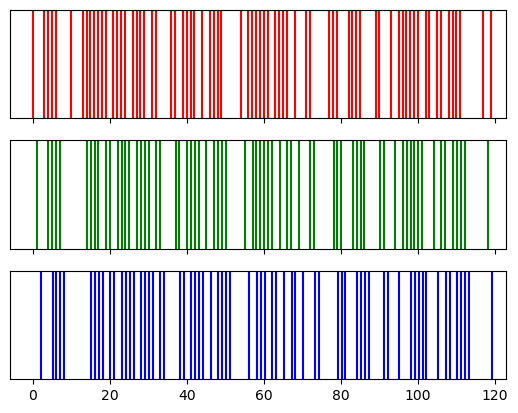

In [98]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"
    

In [100]:
import torch 

class ProbRNN(nn.Module):
    def __init__(self, memory_size):
        super().__init__()

        self.memory_size = memory_size
        self.linear = nn.Sequential(nn.Linear(self.memory_size, 64), nn.Tanh())
        self.lstm = nn.GRU(input_size = 64, hidden_size = 128, num_layers = 1, batch_first = True)
        self.linear_mu = nn.Sequential(nn.Linear(128, self.memory_size))
        self.linear_std = nn.Sequential(nn.Linear(128, self.memory_size))
        self.linear_gmm_weights = nn.Sequential(nn.Linear(128, self.memory_size), nn.Softmax(dim = 1))
        

    def forward(self, x):
      debug_x = x.clone()
      x = self.linear(x)
      x, _ = self.lstm(x)
      mu = self.linear_mu(x)
      # print(mu)
      std = self.linear_std(x)
      std = torch.exp(std)
      gmm_weights = self.linear_gmm_weights(x)
      if torch.isnan(mu).any() or torch.isnan(std).any():
          print(mu, std, debug_x)


      mix_dist = self.build_distrib(mu, std, gmm_weights)

      new_X = self.sample(mu, std)
      log_prob = mix_dist.log_prob(new_X)

    
      return new_X, log_prob


    def build_distrib(self, mus, stds, gmm_weights):
      
      ### This should not work if batch_size != 1. Yet to decide how to deal with this behaviour.
      
      component_dist = torch.distributions.Normal(mus.T, stds.T)
      mix_weight = torch.distributions.Categorical(gmm_weights.T)
      mix_dist = torch.distributions.MixtureSameFamily(mix_weight, component_dist)
      self.mix_dist = mix_dist
      

      return mix_dist

    def sample(self, mu, std):
      size = (std.size(0),)

      X =  mu + self.mix_dist.sample(size)*std

      return X


In [101]:
rede = ProbRNN(memory_size=10)
sum(p.numel() for p in rede.parameters())
# X = torch.rand(size = (20,10))

# new_X, logp = rede(X)

79070

In [102]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

In [204]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):
        
        super().__init__()
        
        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)
        initial_matrix = torch.empty(self.n_processes, self.n_processes)
        nn.init.normal_(initial_matrix, mean=0.0, std=1.0)

        # Apply softmax along dim=1 to ensure each row sums to 1
        self.GrangerMatrix = nn.Parameter(initial_matrix)
        
        self.models = nn.ModuleList([ProbRNN(self.memory_dim) for i in range(self.n_processes)])
        self.sweep_dict = self.make_sweep_dict()
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()), lr=1e-4) for i in range(self.n_processes)]
        self.g_optimizers = [torch.optim.Adam([self.GrangerMatrix], lr=1e-1) for i in range(self.n_processes)]
        self.log_GrangerMatrix = []
        
    def e_step(self, in_weights: torch.Tensor, points_current_pp):
        
        """
        Return the causes for each event of the current_p
        
        """
        
        n = len(points_current_pp)
        rv = []
        in_ = nn.Softmax(dim = 0)(in_weights)
        for i in range(n):
            # in_ = in_weights#nn.Tanh()(in_weights)
            cause = F.gumbel_softmax(
                in_,
                tau = 1,
                hard = False
            )
            rv.append(cause)
        
        return rv

    def em_step(self, n_steps):
        dic = {}
        
        for i in range(self.n_processes):
            dic[i] = []
        
        for step in range(n_steps):
            self.causes = []
            for i_proc in range(self.n_processes):
                rv = self.e_step(
                    self.GrangerMatrix[i_proc],
                    self.processes[i_proc]
                )
                self.causes.append(rv)
            
            
            for i_proc in range(self.n_processes):
                
                # causes_to_ith = self.causes[i_proc] ## causes of ith_proc
                batch_list = self.get_batch_list(i_proc)
                
                dataloader = self.make_dl(batch_list = batch_list, batch_size = 10, drop_last = False)
                self.dataloader = dataloader
                for _, (X, cause_rank) in enumerate(dataloader):

                    loss = self.m_step(i_proc, X, cause_rank)
                    dic[i_proc].append(loss)
                
                if (step + 1) % 5 == 0 or step == 0:
                    print(f'Step: {step + 1}, Model: {i_proc}, Loss: {loss}')
                    
            self.log_GrangerMatrix.append(self.GrangerMatrix)
        return dic

    def m_step(self, i_proc, X, cause_rank):
        #print(mpp.GrangerMatrix.grad)
        model = self.models[i_proc]
        
        self.optimizers[i_proc].zero_grad()
        self.g_optimizers[i_proc].zero_grad()
        
        z, loss = model(X)
        loss = -1*loss.sum(axis = 1)        
        #loss_g = (loss * cause_rank).sum()
        loss_rnn = (loss * cause_rank).sum()
        
        
        if not (torch.isnan(loss_rnn) | torch.isinf(loss_rnn)):
            loss_rnn.backward(retain_graph = False)
            #loss_g.backward(retain_graph = False)
            self.optimizers[i_proc].step()
            self.g_optimizers[i_proc].step()
        
        else:
            print(f'NaN found in epoch: {step}')    

        return loss_rnn.item()

    def make_sweep_dict(self):
        
        dic = {}
        for i in range(self.n_processes):
            target = processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)
        return dic


    def sweep(self, pa, pc):
        events = []
        pa_indices = []  # List to track original indices of pa
    
        # Combine events and track indices for pa
        for i, ia in enumerate(pa):
            events.append((ia, 'a'))
            pa_indices.append(i)  # Track index of 'a' event in pa
    
        for ic in pc:
            events.append((ic, 'c'))
    
        lim = self.memory_dim
    
        events.sort()
        mem = []
        ret = []
        indices = []  # List to store indices relative to pa
    
        pa_idx_counter = 0  # Counter to track which index in pa we are at
    
        for t, e in events:
            if e == 'c':
                if len(mem) >= lim:
                    mem.pop(0)
                mem.append(t)
    
            if e == 'a':
                # Memory is not full yet
                if len(mem) < lim:
                    pa_idx_counter += 1  # Move to the next pa index
                    continue
                # Retrieve deltas from this time to the cause times
                pp = [t - tc for tc in mem]
                ret.append(pp)
                indices.append(pa_indices[pa_idx_counter])  # Save index relative to pa
                pa_idx_counter += 1  # Move to the next pa index
    
        return torch.tensor(ret, dtype=torch.float), indices

    def get_batch_list(self, i_proc):
    
      batch_list = []
      dic = self.sweep_dict
      causes = self.causes[i_proc]
      
      for idx in range(len(causes)):
          n_causes = causes[idx]
        
          for idx_j, cause_rank in enumerate(n_causes):
            
            if idx < dic[i_proc][idx_j][1][0]: ## cannot cause target process
              # self.causes[i_proc][idx][idx_j] = 0.0
              # self.causes[i_proc][idx][i_proc] = 1.0
              continue
            
          
            else:
              where_in_tensor = dic[i_proc][idx_j][1].index(idx)
              app = (dic[i_proc][idx_j][0][where_in_tensor], cause_rank)
              batch_list.append(app)
    
    
      return batch_list
    
    def make_dl(self, batch_list : list, batch_size : int, drop_last : bool):
    
      dataloader = DataLoader(batch_list, batch_size = batch_size, drop_last = drop_last, shuffle = False)
    
      return dataloader

In [205]:
mpp = GrangerMPP(processes, memory_dim = 4)
l = mpp.em_step(n_steps = 50)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [198]:
x, cause_rank = next(iter(mpp.dataloader))

In [199]:
cause_rank

tensor([0.3110, 0.3134, 0.3374, 0.6328, 0.0462, 0.4454, 0.5084, 0.1999, 0.7084,
        0.0917], grad_fn=<StackBackward0>)

In [172]:
mpp.log_GrangerMatrix

[Parameter containing:
 tensor([[-1.3222, -1.3267,  2.0749],
         [ 0.9458,  0.0104,  0.9714],
         [-0.9474,  2.2547, -0.0362]], requires_grad=True),
 Parameter containing:
 tensor([[-1.3222, -1.3267,  2.0749],
         [ 0.9458,  0.0104,  0.9714],
         [-0.9474,  2.2547, -0.0362]], requires_grad=True),
 Parameter containing:
 tensor([[-1.3222, -1.3267,  2.0749],
         [ 0.9458,  0.0104,  0.9714],
         [-0.9474,  2.2547, -0.0362]], requires_grad=True),
 Parameter containing:
 tensor([[-1.3222, -1.3267,  2.0749],
         [ 0.9458,  0.0104,  0.9714],
         [-0.9474,  2.2547, -0.0362]], requires_grad=True),
 Parameter containing:
 tensor([[-1.3222, -1.3267,  2.0749],
         [ 0.9458,  0.0104,  0.9714],
         [-0.9474,  2.2547, -0.0362]], requires_grad=True),
 Parameter containing:
 tensor([[-1.3222, -1.3267,  2.0749],
         [ 0.9458,  0.0104,  0.9714],
         [-0.9474,  2.2547, -0.0362]], requires_grad=True)]

In [39]:
# torch.unique(torch.tensor(mpp.causes[0]), return_counts = True)

Len of losses: [1050, 1000, 1000]


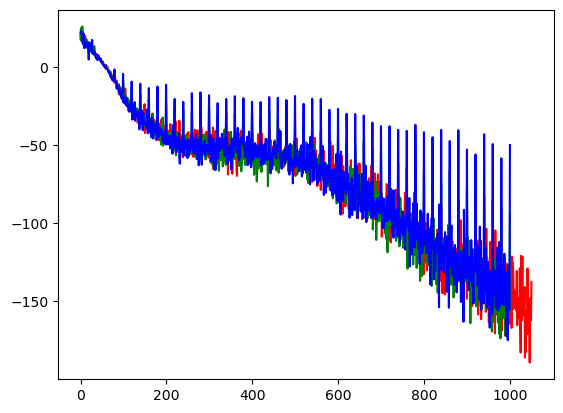

In [109]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

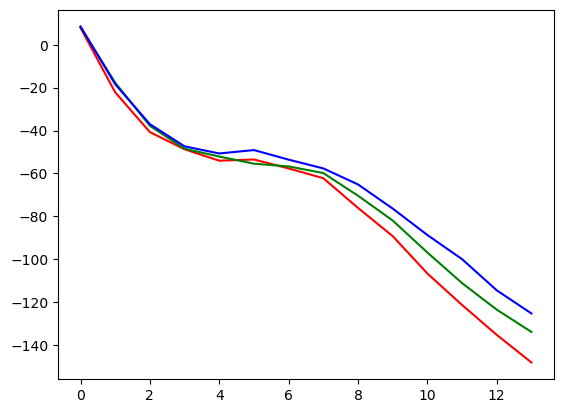

In [110]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

In [40]:
# colors = ['red', 'green', 'blue']
# for i in range(3):
#     plt.plot(final[i], color = colors[i])
 

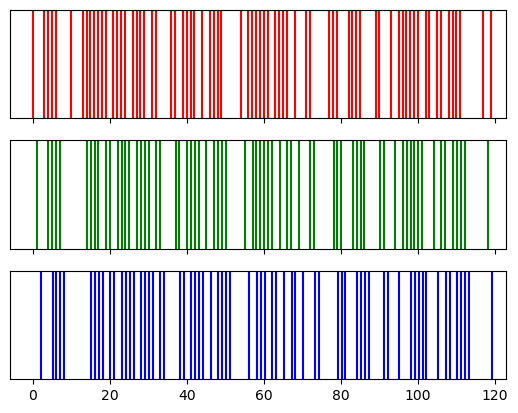

In [111]:
fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

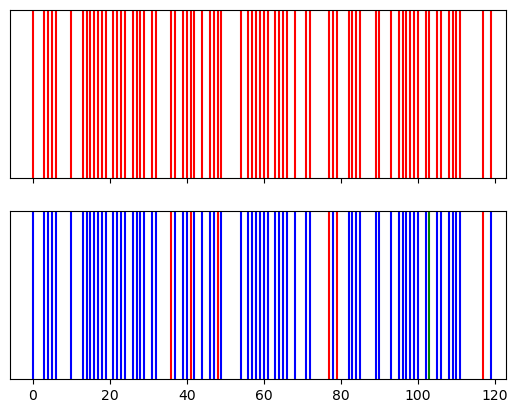

In [121]:
fig, ax = plt.subplots(nrows=2, sharex = True)
colors = ['red', 'green', 'blue']
idx = 0
proc_to_plot = processes[idx].detach().cpu().numpy()
_plot_tick_bars(proc_to_plot, ax[0], color = colors[idx])
_plot_tick_bars_causes(proc_to_plot, ax[1], cause = mpp.causes[idx])


In [95]:
# mpp.log_GrangerMatrix

In [96]:
mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

array([[0.5750364 , 0.21173039, 0.21323325],
       [0.3331062 , 0.33452973, 0.33236405],
       [0.3543213 , 0.23545204, 0.41022664]], dtype=float32)

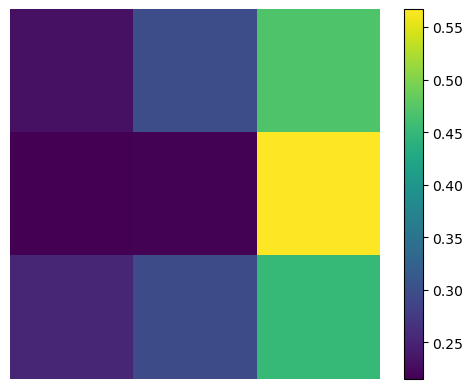

In [284]:
X = mpp.GrangerMatrix.detach().cpu().numpy()
X = (X.T/X.sum(axis = 1)).T
plt.imshow(X)
plt.axis('off')
plt.colorbar()

In [93]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[ 0.996765  , -0.00235457,  0.00471825],
       [ 0.33289954,  0.33716395,  0.3306691 ],
       [ 0.42307693,  0.01438018,  0.56958264]], dtype=float32)

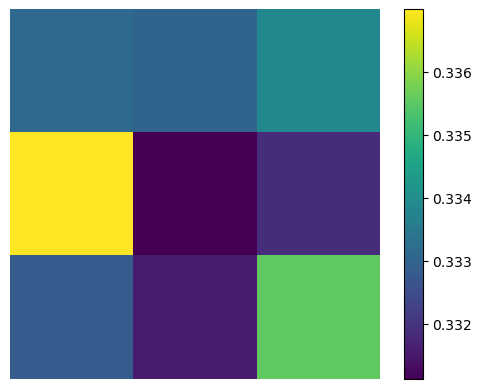

In [173]:
s = mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

plt.imshow(s)
plt.axis('off')
plt.colorbar()

In [134]:
torch.unique(torch.tensor(mpp.causes[idx]), return_counts = True)

(tensor([0, 1, 2]), tensor([50, 52, 51]))